In [ ]:
import numpy as np
import scipy.stats as sps
from seaborn import distplot
from matplotlib import pyplot
import seaborn as sns

from collections import namedtuple
import scipy.stats as sps
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm as tqdm_notebook # tqdm – библиотека для визуализации прогресса в цикле
from collections import defaultdict
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1.5, palette='Set2')
ExperimentComparisonResults = namedtuple('ExperimentComparisonResults',
                                        ['pvalue', 'effect', 'ci_length', 'left_bound', 'right_bound'])

Всем привет! Меня зовут Дима Лунин, я автор курса по экспериментам в Академии Аналитиков Авито. В текущей статье я хочу "обкатать" материал, который мы рассказываем на курсе экспериментов, а также поделиться экспертизой по АБ-тестированию с ребятами, которые только начинают свой путь в аналитике, но уже имеют базовые знания в статистике и в проверке стат. гипотез.

Цель статьи – на примере несложного реального кейса полностью разобрать механику АБ-тестирования, объяснить математику и интуицию за каждым шагом при проведении эксперимента. Кроме того, статья будет снабжена большим количеством кода, который вы сможете потом переиспользовать для себя. В данной статье мы затронем только начальные знания по АБ, а про различные продвинутые механики мы поговорим в следующий раз, если статья вам понравится!


**Важно:** предполагается, что читатель уже хорошо разбирается в статистике, отлично понимает, как проверять статитсические гипотезы, что такое ошибка 1 и 2 рода, мощность. Кроме этого надо знать, что такое доверительный интервал, как и в каких случаях работает t-test, а также как валидировать критерий с помощью механики Монте-Карло. Если вы считаете, что у вас тут есть пробелы в знаниях, то в начале советую просмотреть [курс по статистике от ААА](https://avito.tech/education/statistics), лекции 1-5.

----

План методички будет следующим:

1. Сформулируем кейс, который будем решать.

2. Дадим краткое определение АБ-тестирования и введем всю необходимую статистическую базу под капотом.

3. Запустим AB-тест на реальных данных, но с плохим дизайном эксперимента.

4. Будем исправлять ситуацию: научимся грамотно сетапить эксперимент: размер трафика, длительность теста, определим метрики и прокси метрики.

5. Контр-метрики

6. Грамотная визуализация результатов.

7. Итоги. Соберем все шаги из статьи в краткое саммари.

### Задача

Представьте, что к вам обратился ваш менеджер продукта с предложением:


> Мы изменили описание наших услуг продвижения на сайте и их интерфейс, чтобы сделать их более понятными и привлекательными для пользователей. Мы ожидаем, что это приведет к увеличению спроса на нашу услугу. Как понять, что стало лучше?

Как же нам подойти к решению этой задачи?

------

Для решения такого типа задач была придумана маханика **AB-тестирования**. Она состоит из нескольких ключевых шагов:
- Аудитория сервиса делится на 2 или более групп: контрольную, в которой не будут вноситься изменения, и тестовую, в которой будет протестирована новая функция.
- Собираются данные в каждой из групп в течение некоторого времени.
- Подводятся итоги теста. Показатели в разных группах сравниваются и на их основании определяется, тестируемая гипотеза успешна или нет.

**Важно: перечислены не все шаги АБ-тестирования, а лишь ключевые, необходимые для понимания методологии. Далее мы будем их дополнять.**

## Часть 1. Первый АБ-тест.

### Первый искусственный АБ-тест.

Давайте рассмотрим теоретический пример, чтобы понять, как работает AB-тест. Определим, какую именно продуктовую гипотезу мы проверяем: рост спроса на услугу продвижения. А зачем это компании? Чтобы растить целевую метрику &mdash; выручку.  Допустим, мы хотим рассчитать рост выручки за одну неделю.


**Когда мы получим больше выручки?** В случае, если будет внедрено новое изменение, или если его не будут применять? Чтобы ответить на этот вопрос, в идеально честной картине нам нужно сравнить выручку в 2 параллельных мирах: есть 1 мир, где раскатано изменение и другой мир, где не катили.

Определим 2 выборки в идеальном кейсе:

- **Выборка в мире 1**: $T_1^w, T_2^w,..., T_{N}^w$ — это выручка от **всех** пользователей за неделю в мире (world, отсюда буква $w$ 🙃), где произошло изменение.
- **Выборка в мире 2**: $C_1^w, C_2^w,..., C_{N}^w$ — это выручка от **всех** пользователей за неделю в мире, где не было изменений.

Тогда, чтобы понять, надо ли катить изменение или нет, нам надо сравнить $\sum T^w_i$ и $\sum C^w_i$: если сумма $T^w$ больше, то надо катить изменение, а иначе нет. Но в реальности, конечно же, такое невозможно: нельзя сделать 2 мира. Поэтому и была придумана механика АБ-тестирования, в которой всех пользователей делят на 2 группы, но уже в 1 мире.

В таком случае у нас есть две выборки:

- **Тестовая выборка**: $T_1, T_2,..., T_{K}$ — это выручка от пользователей за неделю, которые были в группе, где произошло изменение. Далее мы будем обозначать эту выборку буквой $T$.
- **Контрольная выборка**: $C_1, C_2,..., C_{M}$ — это выручка пользователей за неделю из группы, где не было изменений. Эту выборку мы будем обозначать буквой $C$.

Где размер контрольной + тестовой групп равно N: $K + M = N$.

 Dыборки $T^w, C^w$ определены для каждого пользователя, а $T, C$ известны только для какой-то части юзеров, причем у одного пользователя известно либо значение $T_i$, либо $C_i$.

Как узнать, действительно ли $\sum T^w_i > \sum C^w_i$, имея только $T$ и $C$? Кроме этого, хочется, чтобы наши результаты были валидны не только для текущего множества из N людей, которые будут юзерами сервиса на след неделе, но и для любого другого множества пользователй из той же генеральной совокупности. Например, если в будущем в наш сервис придут новые пользователи.

Здесь на помощь приходит теория вероятности и [Закон Больших Чисел (ЗБЧ)](https://ru.wikipedia.org/wiki/Закон_больших_чисел): $\dfrac{\sum_1^N T^w_i – C^w_i}{N} \stackrel{p}{\rightarrow} \mathbb{E} [T^w – C^w], \ N \rightarrow \infty$. Но ведь $\mathbb{E} [T^w] = \mathbb{E} [T];\ \mathbb{E} [C^w] = \mathbb{E} [C]$. А значит,

$$\dfrac{\sum_1^N T^w_i – C^w_i}{N} \approx \mathbb{E} [T] – \mathbb{E} [C], \ N \rightarrow \infty.$$

Поэтому, чтобы определить, какая ситуация лучше — контрольная или тестовая, достаточно сравнить математические ожидания наших выборок в АБ-тесте. Такой подход позволяет нам решить две проблемы, о которых мы говорили ранее.

----

Теперь мы можем сформулировать нашу продуктовую гипотезу на языке статистики:

$$
H_0: \mathbb{E} C = \mathbb{E} T \ vs. H_1: \mathbb{E} C < \mathbb{E} T
$$

Теперь давайте перейдем к практике и посмотрим, как это работает на искусственном примере. Рассмотрим 2 распределения выручки, которые могли бы возникнуть: без изменения и с ним.

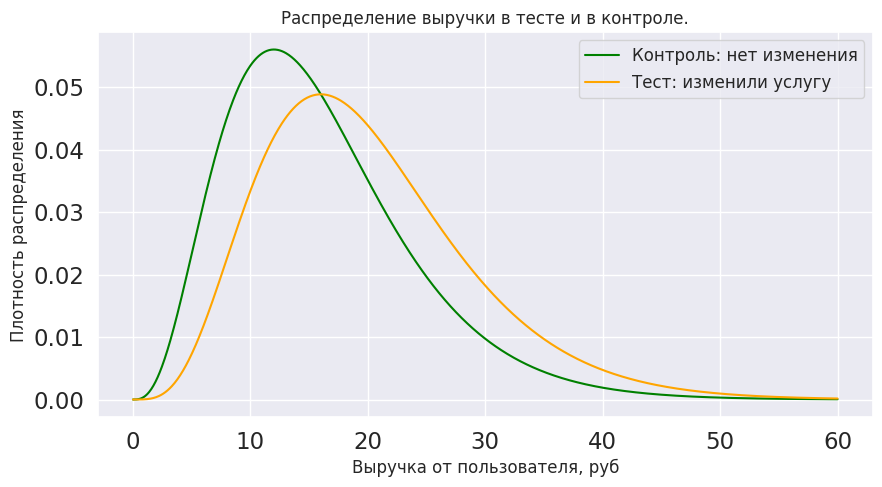

In [ ]:
np.random.seed(42)
control_distribution = sps.gamma(a=4, scale=4)
test_distribution = sps.gamma(a=5, scale=4)

x_ticks = np.linspace(0, 60, 1000)

plt.figure(figsize=(10, 5))
plt.title("Распределение выручки в тесте и в контроле.", fontsize=12)
plt.plot(x_ticks, control_distribution.pdf(x_ticks), color='green', label='Контроль: нет изменения')
plt.plot(x_ticks, test_distribution.pdf(x_ticks), color='orange', label='Тест: изменили услугу')
plt.legend(fontsize=12)
plt.xlabel('Выручка от пользователя, руб', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.show()

Мы видим, что рыжее распределение чуть "правее" и имеет визуально большее мат. ожидание.

Насемплируем возможные выборки в тесте и в контроле.

In [ ]:
control = control_distribution.rvs(10000)
test = test_distribution.rvs(10000)

Теперь мы можем провести T-test, чтобы проверить нашу гипотезу, и получить результаты. Но до этого нам необходимо зафиксировать уровень значимости (или FPR, false positive rate).

#### Какая будет ошибка первого рода?

В реальности это всегда не самая тривиальная задача трейдоффа между мощностью и FPR (false positive rate). Если alpha будет очень большой, то вы будете часто детектировать эффект там, где его нет. Вы будете чаще катить потенциально опасные изменения для бизнеса. А если alpha мала, то ваш бизнес будет в застое: вы не будете катить улучшающие бизнес изменения.

В большинстве случаев, если вам нам с чего-то начать, то я предлагаю брать одностороннюю `alpha` на уровне 2.5%. Это решение основывается на двух факторах:
1. Такой уровень ошибок приемлем для бизнеса. Это подтверждается опытом большинства компаний, которые используют именно такой FPR и продолжают успешно развиваться.
2. Обычно такая `alpha` оказывается достаточно чувствительной для проверки различных гипотез, обеспечивая хорошую мощность для вашего критерия.

Но при этом на практике есть множество кейсов, где выбор альфы 2.5% плох. Например:
- Нельзя брать большую `alpha` (где даже 2.5% много), если вы заранее знаете, что ваше изменение маловероятно к чему-то приведет. Например, если вы тестируете рассылку и смотрите в качестве одной из метрик доступность сайта Авито, то брать альфу даже 1% нет смысла. Вы не повлияте рассылками на эту метрику, все прокрасы здесь ложные.
- Нельзя брать большую `alpha`, если вы тестируете критический функционал, который потенциально может ухудшить сайт. В этом кейсе вам важна ошибка первого рода.
- Вы можете изменять `alpha` в большую сторону, если вы знаете, что у вас наверняка есть положительное изменение. Например, вы запустили маркетинговую рекламную кампанию.

Также важно помнить следующее: **односторонняя альфа и двусторонняя альфы отличаются!**
Например, в нашем случае мы будем использовать дефолтную одностороннюю `alpha` в 2.5%. Но если мы решим использовать двусторонний критерий, то его `alpha` увеличится до 5%.

В нашем кейсе мы возьмем одностороннюю альфа равной 5% по 2 причинам:
1. Метрику выручки сложно прокрасить как мы увидим далее.
2. Мы уверены, что наше изменение положительно повлияет на услугу продвижения, (например, в реальности такой вывод можно сделать исходя из UX-тестов). Это как раз пример 3 кейса, где альфу можно менять.

### Какой критерий выбрать: односторонний или двусторонний?

В нашем конкретном случае мы должны использовать односторонний критерий. Да и на практике ваша гипотеза почти всегда будет односторонней: вас интересует только улучшение(а иногда ухудшение) метрики относительно контрольной группы. В противном случае вы не будете раскатывать изменения.

Однако на практике немногие применяют односторонний критерий, так как он не является универсальным. Это означает, что для разных ситуаций вам потребуется три различных критерия, проверяющих рост, падение или изменение математического ожидания метрики.

Поэтому легче использовать универсальный двусторонний критерий и `alpha` в 2 раза большую.

In [ ]:
sps.ttest_ind(test, control, equal_var=False, alternative='two-sided').pvalue

np.float64(5.801425609242045e-221)

Мы видим, что двусторонний $\text{p-value} < 0.1 (= 0.05 \cdot 2)$, но мы не понимаем, в какую сторону у нас эффект. Поэтому давайте напишем удобную функцию-обертку над T-test, которая давала бы всю необходимую инофрмацию для двустроннего критерия: `pvalue`, `effect`, а также строила бы доверительный интервал.

In [ ]:
def absolute_ttest(control, test, two_sided_alpha):
    mean_control = np.mean(control)
    mean_test = np.mean(test)

    var_mean_control  = np.var(control) / len(control)
    var_mean_test  = np.var(test) / len(test)

    difference_mean = mean_test - mean_control
    difference_mean_var = var_mean_control + var_mean_test
    difference_distribution = sps.norm(loc=difference_mean, scale=np.sqrt(difference_mean_var))

    left_bound, right_bound = difference_distribution.ppf([two_sided_alpha / 2, 1 - two_sided_alpha / 2])
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(difference_distribution.cdf(0), difference_distribution.sf(0))
    effect = difference_mean
    return ExperimentComparisonResults(pvalue, effect, ci_length, left_bound, right_bound)

In [ ]:
results = absolute_ttest(control, test, two_sided_alpha=0.1)

print(f'Effect: {round(results.effect, 3)},({round(results.left_bound, 3)}, {round(results.right_bound, 3)})')
print(f'two-sided pvalue: {round(results.pvalue * 100, 1)}%, one-sided pvalue: {round(results.pvalue / 2 * 100, 1)}%')

Effect: 3.859,(3.662, 4.057)
two-sided pvalue: 0.0%, one-sided pvalue: 0.0%


Это значит, что мы можем отвергнуть гипотезу в пользу $H_1$ на уровне значимости 5% (одностороннем) и внедрять изменения.


### Как делить пользователей?

Важно отметить, что для корректной работы T-test необходимо, чтобы тестовые и контрольные группы пользователей были репрезентативны для рыжего и зеленого распределений (в случае изменения и без него).  Для этого достаточно поделить пользователей вашего сервиса **случайно**, что следует из свойств распределения и после небольших махинаций с теорвером. У вас не будет никакого смещения и мат. ожидание тестовых и контрольных выборок будут равны $\mathbb{E} T^w$ и $\mathbb{E} C^w$ соответственно.

В таком кейсе вы гарантируете, что ваши выборки не будут смещены относительно генеральной совокупности, а также репрезентативны.


----

**Итоги:**

Из этой части мы выяснили:
- Какую статистическую гипотезу следует использовать в нашем AB-тесте.
- Какой критерий использовать на практике.
- Как разделить пользователей на группы. Случайное разбиение является достаточным.

Теперь мы готовы перейти к AB-тесту на реальных данных и посмотреть, что у нас получится.

### AB-тест на реальных данных с плохим дизайном

Теперь давайте рассмотрим, как AB-тестирование работает на практике, используя реальные данные:

- **Статистическая гипотеза**: $H_0:$ выручка не изменилась или упала VS. $H_1:$ выручка выросла
- **Сплитование пользователей**: Мы случайным образом разделим всех пользователей сервиса на две группы: контрольную и тестовую, но в каждой из которых будет по 10% от общего трафика. То есть мы будем прводить наш AB на 20% пользователей Авито. В контрольной группе мы оставим все как есть, а в тестовой запустим новое описание услуги.
    - Почему так мало пользователей в эксперименте? Мы опасаемся, что другие AB-тесты, которые проводятся параллельно, могут повлиять на результаты нашего анализа и сделать их невалидными. Чем меньше размер выборки, тем более вероятно, что вы сможете найти "чистых" пользоватлей, не находящихся ни в чьем другом эксперименте.  
- **Длительность теста**: Как и в искусственном примере, мы проведем эксперимент в течение одной недели.
- **Анализ результатов**: Мы воспользуемся t-тестом для получения стат. значимых результатов.

Давайте наконец приступим к анализу реальных данных!

In [ ]:
exp_df = pd.read_csv('simple_df_ab1.csv')

In [ ]:
exp_df.head()

,user_id,group,promotion_revenue
0,328005191,control,0.000000
1,328017524,test,675.043322
2,328018610,test,0.000000
3,328022724,test,0.000000
4,328023511,test,0.000000


У нас 3 столбца: пользователь, его группа и выручка от него в услугах продвижения.

Посмотрим, как распределена выручка:

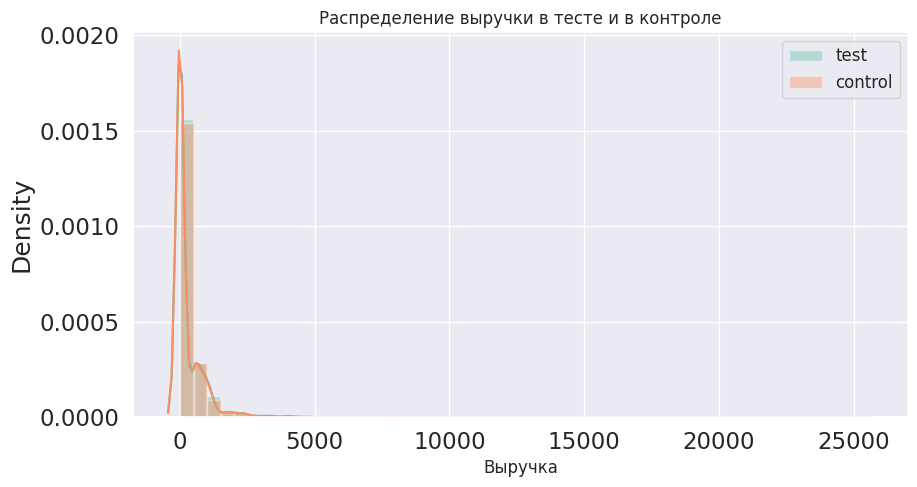

In [ ]:
test = np.array(exp_df[(exp_df['group'] == 'test')]['promotion_revenue'])
control = np.array(exp_df[(exp_df['group'] == 'control')]['promotion_revenue'])

plt.figure(figsize=(10, 5))
plt.title('Распределение выручки в тесте и в контроле', fontsize=12)
sns.distplot(test, label='test')
sns.distplot(control, label='control')
plt.legend(fontsize=12)
plt.xlabel("Выручка", fontsize=12)
plt.show()

Как видно, у нас есть как мелкие пользователи, так и очень крупные.

In [ ]:
test = np.array(exp_df[(exp_df['group'] == 'test')]['promotion_revenue'])
control = np.array(exp_df[(exp_df['group'] == 'control')]['promotion_revenue'])

Давайте проанализируем, как увеличилась выручка на одного пользователя:

In [ ]:
revenue_uplift_per_user = np.mean(test) - np.mean(control)
print(f"оценка прироста выручки на пользователя: {round(revenue_uplift_per_user, 2)} руб.")

оценка прироста выручки на пользователя: 16.31 руб.


In [ ]:
results = absolute_ttest(control, test, two_sided_alpha=0.1)

print(f'Effect: {round(results.effect, 1)} руб,({round(results.left_bound, 1)}, {round(results.right_bound, 1)})')
print(f'two-sided pvalue: {round(results.pvalue * 100, 1)}%, one-sided pvalue: {round(results.pvalue / 2 * 100, 1)}%')

Effect: 16.3 руб,(-11.9, 44.5)
two-sided pvalue: 34.1%, one-sided pvalue: 17.1%


В результате теста мы получили p-value больше 5%, что означает, что тест был «серым». Мы не можем точно сказать, стало лучше или хуже.

Как быть в такой ситуации? Мы не можем внедрить изменение, поскольку нет уверенности, что мы не вырастили выручку.

В подобных случаях неопытный аналитик сразу говорит, что нельзя внедрять изменение, а хороший аналитик никогда бы не запустил такой тест)

**Первое, что необходимо было сделать, это убедиться, что вы действительно могли обнаружить ожидаемое изменение.** Давайте вспомним, что такое [MDE — минимальный детектируемый эффект](https://github.com/avito-tech/applied_statistics/blob/main/Stat%20power.ipynb).

- Если MDE очень большой (например, нужно увеличить выручку на 100%), то понятно, почему вы не заметили статистически значимого эффекта.
- Если MDE небольшой, то есть он меньше ожидаемого вами прироста выручки, то ваш AB-тест хорошо подготовлен, и нужно искать другие причины, почему он не сработал. Но об этом мы поговорим в другой раз.

Давайте проверим MDE нашего теста. Вспомним, как выглядит формула MDE для t-теста:

$MDE = \left(z_{1-\alpha} + z_{1-\beta}\right)  \cdot \sqrt{\dfrac{S^2_T}{N} + \dfrac{S^2_C}{M}}$, где $N$ и $M$ — размеры теста и контроля.

Какую мощность выбрать? Давайте возьмем 80%: если эффект есть, то в 4 из 5 кейсов мы его обнаружим.

Тогда наш MDE в эксперименте будет выглядеть следующим образом:

In [ ]:
alpha = 0.05
beta = 0.2
MDE_absolute = (sps.norm().ppf(1 - alpha) + sps.norm().ppf(1 - beta)) * np.sqrt(np.var(test) / len(test) + np.var(control)  / len(control))
MDE_absolute

np.float64(42.620918220693696)

42 рубля в среднем на человека – это много или мало? Сложно сказать. Давайте посмотрим, как это соотносится со средней выручкой, чтобы понять, насколько эта сумма велика.

In [ ]:
MDE_rel = MDE_absolute / np.mean(control)
print(f"Относительный MDE для метрики выручки на пользователя равен {round(MDE_rel * 100, 1)}%")

Относительный MDE для метрики выручки равен 15.8%


Чтобы заметить изменения в выручке, нам нужно было увеличить её в нашем эксперименте на 16% благодаря нововведению. Очевидно, что изменение дизайна в уже существующем сервисе не может привести к таким результатам. Поэтому данный AB-тест оказался бессмысленным.

А могли ли мы это понять до того, как провели эксперимент?

### Предсказание MDE до начала эксперимента

Сегодня мы уже научились определять MDE после завершения эксперимента. Это интересно, но не имеет практического значения. Обнаружить после проведения теста, что он оказался бесполезным, было бы неразумно и привело бы к пустой трате ресурсов и времени компании.

Поэтому важно научиться прогнозировать, будет ли AB-тест иметь смысл и какой у него будет MDE. Для этого была разработана следующая методика:

1. Собирается исторический набор данных, желательно максимально приближенный к запланированному началу реального AB-теста.
2. Запускается АА-тест на основе собранных данных с теми же параметрами, что и в предполагаемом эксперименте. Важно отметить, что в АА-тесте нет различий между тестируемой и контрольной группами.
3. На основе результатов АА-теста рассчитывается MDE, как в реальном AB-тесте.

Практика показывает, что этот метод позволяет с высокой точностью предсказать относительный MDE эксперимента. Давайте рассмотрим его в действии.

----

#### 1. Сбор датасета

In [ ]:
before_exp_dataset = pd.read_csv('before_exp_dataset_ab1.csv')

In [ ]:
before_exp_dataset.head()

,user_id,week_dt,promotion_revenue,promotion_listings,promotion_listers
0,4154500915,27,0.000000,0,0
1,383176571,22,0.000000,0,0
2,335040081,26,767.824001,1,1
3,408303511,22,0.000000,0,0
4,391600045,30,0.000000,0,0


Здесь в датасете есть все 100% пользователей и дополнительные метрики, помимо выручки. А также группировка данных по неделям.
- `user_id` — id пользователя
- `week_dt` — неделя в году, за которую собирались данные
- `promotion_revenue` — выручка от услуг продвижения

*Дополнительно*
- `promotion_listings` — количество объявлений, к которым была применена услуга продвижения
- `promotion_listers` — количество пользователей, купивших услугу продвижения

**Важно:**
- В данном случае у нас нет колонки `group`, так как мы пока не поделили пользователей на тест и контроль
- 1 пользователь встречается в датасете больше, чем 1 раз! Это связано с тем, что юзер может совершать разные покупки в разные недели

Поэтому давайте создадим функцию-помощник, которая будет группировать данные пользователя за разные недели в 1 строчку, чтобы избавиться от зависимостей в данных. При этом количество объединяемых недель будет параметром функции.

In [ ]:
def make_grouped_user_dataset(before_df, weeks_in_test):
    # максимальная доступная неделя при сетапе теста
    max_week = before_exp_dataset['week_dt'].max()

    # Оставляем только те недели, которые больше max_week - weeks_in_test.
    # Таким образом мы отберем ровно weeks_in_test недель.
    curr_df = before_df[(before_df['week_dt'] > max_week - weeks_in_test)][
        ['user_id', 'promotion_revenue', 'promotion_listings', 'promotion_listers']
    ]
    # promotion_listers группируется как `max`, исходя из логики метрики: хотя бы раз за время АА-теста воспользовался услугой продвижения
    curr_df = pd.DataFrame(curr_df.groupby(['user_id']).agg(
        {'promotion_revenue': 'sum',
         'promotion_listings': 'sum',
         'promotion_listers': 'max'
        }
    ).reset_index()).fillna(0)

    return curr_df

In [ ]:
np.random.seed(42)
prepaired_for_aa_dataset = make_grouped_user_dataset(before_exp_dataset, weeks_in_test=1)
# Суммарно 20 процентов: 10 в тесте и 10 в контроле
prepaired_for_aa_dataset = prepaired_for_aa_dataset.sample(frac=0.2)

#### 2. Создание АА-теста

Теперь нам необходимо случайным образом разделить пользователей на две группы: тестовую и контрольную.

In [ ]:
np.random.seed(42)
prepaired_for_aa_dataset['group'] = np.random.choice(['test', 'control'], size=len(prepaired_for_aa_dataset))

metric = 'promotion_revenue'
aa_test = np.array(prepaired_for_aa_dataset[(prepaired_for_aa_dataset['group'] == 'test')][metric])
aa_control = np.array(prepaired_for_aa_dataset[(prepaired_for_aa_dataset['group'] == 'control')][metric])


#### 3. Считаем MDE на AA-тесте

In [ ]:
alpha = 0.05
beta = 0.2
MDE_absolute = (sps.norm().ppf(1 - alpha) + sps.norm().ppf(1 - beta)) * np.sqrt(np.var(aa_test) / len(aa_test) + np.var(aa_control)  / len(aa_control))

MDE_rel = MDE_absolute / np.mean(aa_control)
print(f"Абсолютный MDE для метрики выручки на пользователя равен {round(MDE_absolute, 1)} руб.")
print(f"Относительный MDE для метрики выручки на пользователя равен {round(MDE_rel * 100, 1)}%")

Абсолютный MDE для метрики ARPU равен 42.6 руб.
Относительный MDE для метрики ARPU равен 18.5%


Мы видим, что абсолютный MDE и относительный MDE оказались схожи с экспериментальными. Это свидетельствует о том, что наша текущая методика прогнозирования MDE до начала теста работает!

Однако, стоит отметить, что в реальной жизни абсолютный MDE, полученный в ходе АА-теста, зачастую отличается от фактического из-за влияния сезонных факторов. Однако относительный MDE, как показывает практика, остается неизменным.

**Подводя итог:** мы успешно научились предсказывать MDE теста еще до его начала. Это представляет собой один из ключевых элементов в процессе подготовки AB-теста. Как мы убедились, если бы мы провели эту процедуру заранее в нашем исходном кейсе, то смогли бы избежать плачевных результатов эксперимента.

-----

**Вывод всего раздела:** некачественный сетап эксперимента — это гарантия того, что AB-тесты будут серыми и бессмысленными.

## Часть 2. Хорошо подготовленный АБ-тест на реальных данных.

### 2.1 Грамотная подготовка теста

Мы научились прогнозировать MDE теста заранее. Но сейчас нам это не помогает: мы лишь поняли, что текущие праметры эксперимента не позволят замерить эффект.

Чтобы избежать подобной ситуации, перед началом теста важно тщательно продумать его параметры. Основываясь на двух приведенных выше примерах, можно выделить несколько ключевых компонентов:

- **Сплитование.** Процент пользователей, выделяемый для каждой группы.
- **Длительность теста.**
- **Метрика и статистическая гипотеза.**

Давайте подробнее рассмотрим, как каждый из этих параметров влияет на MDE.

-----

В дальнейшем мы все время будем делать улучшения в сетапе теста, и надо понимать, насколько стало лучше. Оценивать мы будем по MDE, поэтому сразу же выпишем функцию, которая будет его считать.

In [ ]:
def get_relative_MDE(test, control, alpha, beta):
    MDE_absolute = (sps.norm().ppf(1 - alpha) + sps.norm().ppf(1 - beta)) * \
        np.sqrt(np.var(test) / len(test) + np.var(control)  / len(control))
    MDE_rel = MDE_absolute / np.mean(control)
    return MDE_rel

#### 2.1.1 Сплитование пользователей



Давайте посмотрим, как меняется MDE при увеличении размера тестовых групп. Это самый первый и понятный способ увеличения чувстивтельности теста. Пусть $N$ — число людей в сервисе за неделю. Пусть в тесте у нас доля пользователей будет $a$, а в контроле – $b$.

Математически мы знаем, что если дисперсия теста от контроля ничем не отличается (а на практике часто так и бывает), то $S^2_T = S^2_С = S^2$, и

$$
\begin{align}
\text{MDE}(a, b) &= \left(z_{1-\alpha} + z_{1-\beta}\right) \cdot \sqrt{\dfrac{S^2_T}{a \cdot N} + \dfrac{S^2_C}{b \cdot N}} =\\
    &= \left(z_{1-\alpha} + z_{1-\beta}\right)  \cdot \sqrt{\dfrac{S^2}{N}}  \cdot \sqrt{ \dfrac{1}{a} + \dfrac{1}{b}} = \\
    &= \text{const}  \cdot \sqrt{ \dfrac{1}{a} + \dfrac{1}{b}}
\end{align}
$$

Теперь мы поняли, как MDE зависит от параметров $a$, $b$. Несложно показать, что наименьший MDE будет, когда $a = b = 0.5$. Давайте посмотрим в нашем примере, как сократится MDE из-за этого.



In [ ]:
def compare_mde(current_a, current_b, new_a, new_b):
    return np.sqrt(1/current_a + 1/current_b) / np.sqrt(1/new_a + 1/new_b)

compare_mde(0.1, 0.1, 0.5, 0.5)

np.float64(2.23606797749979)

То есть если мы будем использовать разбиение 50:50 вместо 10:10, то доверительный интервал сократится в 2,2 раза! Но это значение мы получили теоретически, а не на практике. Давай же его проверим на нашем реальном тесте с реальными данными: совпадает ли теория с практикой?

In [ ]:
def check_mde_reduce_from_size(grouped_dataset, current_t, current_c, new_t, new_c):
    """
    Функция для сравнения MDE в текущем варианте сплитования и в новом.
    Параметры:
        - grouped_dataset: сгруппированный поюзерный датасет, на осоновании которого будут сравниваться MDE
        - current_t: доля пользователей в тесте в текущем сетапе
        - current_c: доля пользователей в контроле в текущем сетапе
        - new_t: доля пользователей в тесте в новом сетапе
        - new_c: доля пользователей в контроле в новом сетапе
    Возвращает:
        - отношение MDE_current / MDE_new
    """


    grouped_dataset['group_current'] = np.random.choice(['test', 'control', '-'],
                                                        p=[current_t, current_c, 1 - current_c - current_t],
                                                        size=len(grouped_dataset))
    grouped_dataset['group_new'] = np.random.choice(['test', 'control', '-'],
                                                    p=[new_t, new_c, 1 - new_t - new_c],
                                                    size=len(grouped_dataset))
    metric = 'promotion_revenue'


    test_curr = np.array(grouped_dataset[(grouped_dataset['group_current'] == 'test')][metric])
    control_curr = np.array(grouped_dataset[(grouped_dataset['group_current'] == 'control')][metric])

    test_new = np.array(grouped_dataset[(grouped_dataset['group_new'] == 'test')][metric])
    control_new = np.array(grouped_dataset[(grouped_dataset['group_new'] == 'control')][metric])

    MDE_current = get_relative_MDE(test_curr, control_curr, alpha=0.05, beta=0.2)
    MDE_new = get_relative_MDE(test_new, control_new, alpha=0.05, beta=0.2)
    return MDE_current / MDE_new

In [ ]:
np.random.seed(42)
grouped_dataset =  make_grouped_user_dataset(before_exp_dataset, 1)
check_mde_reduce_from_size(grouped_dataset, current_t=0.1, current_c=0.1, new_t=0.5, new_c=0.5)

np.float64(1.994272235436634)

Как мы видим, значения оказались близкими, но не совпали. Это логично: мы поделили здесь датасет одним способом, а могли и другим. А что, если мы посмотрим среднее изменение при разных сплитованиях? Например, проведем Монте-Карло, где каждый раз по-разному будем семплировать датасет. И посмотрим, какое в среднем будет отношение MDE изначального сетапа к MDE предлагаемого сетапа?

  0%|          | 0/1000 [00:00<?, ?it/s]

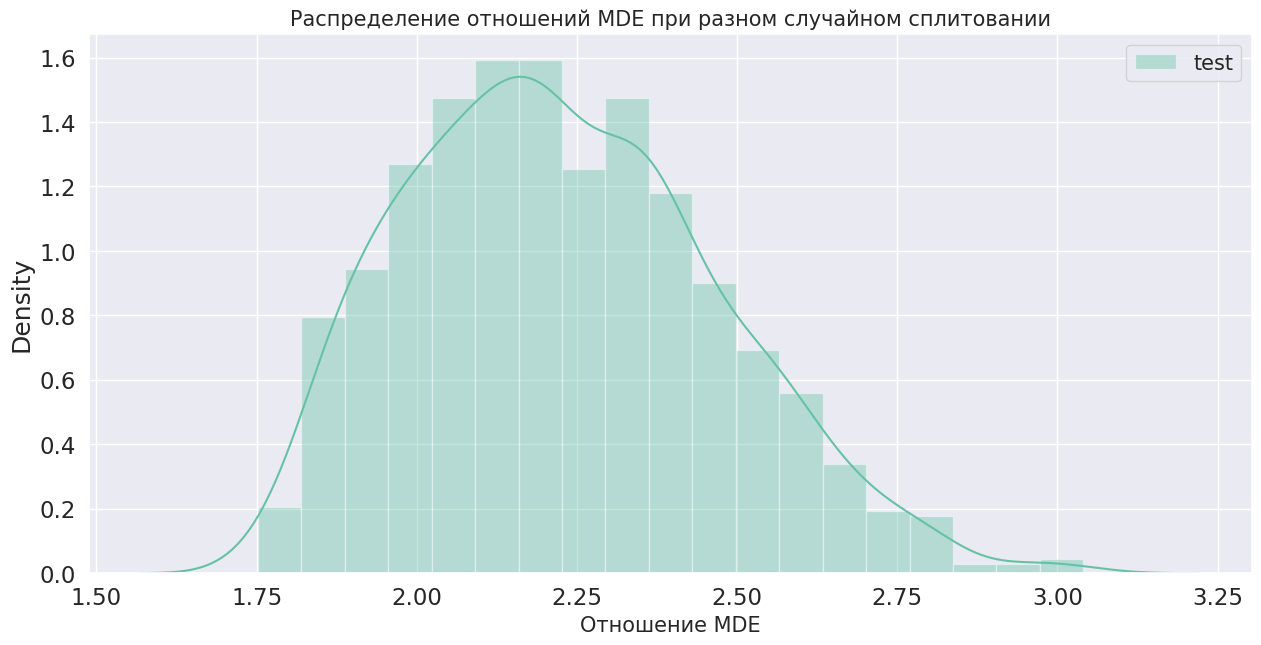

MDE_start_split / MDE_best_split: 2.226


In [ ]:
np.random.seed(42)

mde_cmp = []
MC_size = 1000

grouped_dataset = make_grouped_user_dataset(before_exp_dataset, 1)

for _ in tqdm_notebook(range(MC_size)):
    curr_mde_cmp = check_mde_reduce_from_size(grouped_dataset, current_t=0.1, current_c=0.1, new_t=0.5, new_c=0.5)
    mde_cmp.append(curr_mde_cmp)

plt.figure(figsize=(15, 7))
plt.title('Распределение отношений MDE при разном случайном сплитовании', fontsize=15)
sns.distplot(mde_cmp, label='test')
plt.legend(fontsize=15)
plt.xlabel("Отношение MDE", fontsize=15)
plt.show()

print(f'MDE_start_split / MDE_best_split: {round(np.mean(mde_cmp), 3)}')

Да, при разных случайных разбиениях отношение MDE может меняться, но в среднем оно составляет около 2,23, как и предполагалось! Это означает, что если мы разделим пользователей не 10:10%, как изначально планировали, а 50:50, то ожидаемое сокращение MDE будет более чем в два раза!

Поэтому, в нашем кейсе мы разобьем трафик 50:50.

**Почему тогда каждый раз не проводить тест 50 на 50?**

Можно выделить несколько причин:

1. У вас может быть несколько параллельных экспериментов, которые могут искажать результаты друг друга.
2. Ваше изменение может быть очень рискованным для сервиса и повлечь за собой снижение ключевых показателей компании. Поэтому вы стараетесь сделать тестовую группу как можно меньше.
3. *Ваш тест может оказывать "сетевой эффект" на контрольную группу. Чтобы минимизировать его влияние, вы ограничиваете размер тестовой группы. Более подробно о сетевых эффектах мы поговорим в дальнейших методичках по курсу.

#### 2.1.2 Выбор длительности теста


**Как не надо считать длительность теста?**

Чаще всего, если вы будете смотреть в интернете, как считать длительность теста, то наткнетесь на формулу в случае разделения пользователей 50 на 50:

$$N = 2 \left(\dfrac{z_{1 - \alpha} + z_{1 - \beta}}{\text{MDE}}\right)^2 S^2,$$

где $N$ – размер одной группы, а MDE – ваш желаемый эффект, который вы хотите детектировать.

Она напрямую следует из формулы:
$\text{MDE} = \left(z_{1-\alpha} + z_{1-\beta}\right) \cdot \sqrt{\dfrac{S^2_T}{N} + \dfrac{S^2_C}{N}} \approx \left(z_{1-\alpha} + z_{1-\beta}\right) \cdot \sqrt{2} \cdot \sqrt{\dfrac{S^2}{N}} $


В чем проблема такого решения? Их на самом деле две:
1) Вы не знаете, как с ростом длительности теста будет увеличиваться размер выборки. Функция зависимости N от длительности теста неизвестна!
2) Также у нас есть проблема дисперсии: **она зависит от длительности теста!** На самом деле у нас формула: $N = 2 \left(\dfrac{z_{1 - \alpha} + z_{1 - \beta}}{\text{MDE}}\right)^2 \cdot S^2(T),$ где $S^2(T)$ – Функция оценки дисперсии относительно длительности теста.  Чем она больше, тем больше дисперсия. Это возникает из-за того, что новые пользователи приходят, а старые активные пользователи начинают тратить все больше и больше в сервисе!

Давайте посмотрим на нашем кейсе, как изменяется оценка дисперсии с ростом длительности теста:

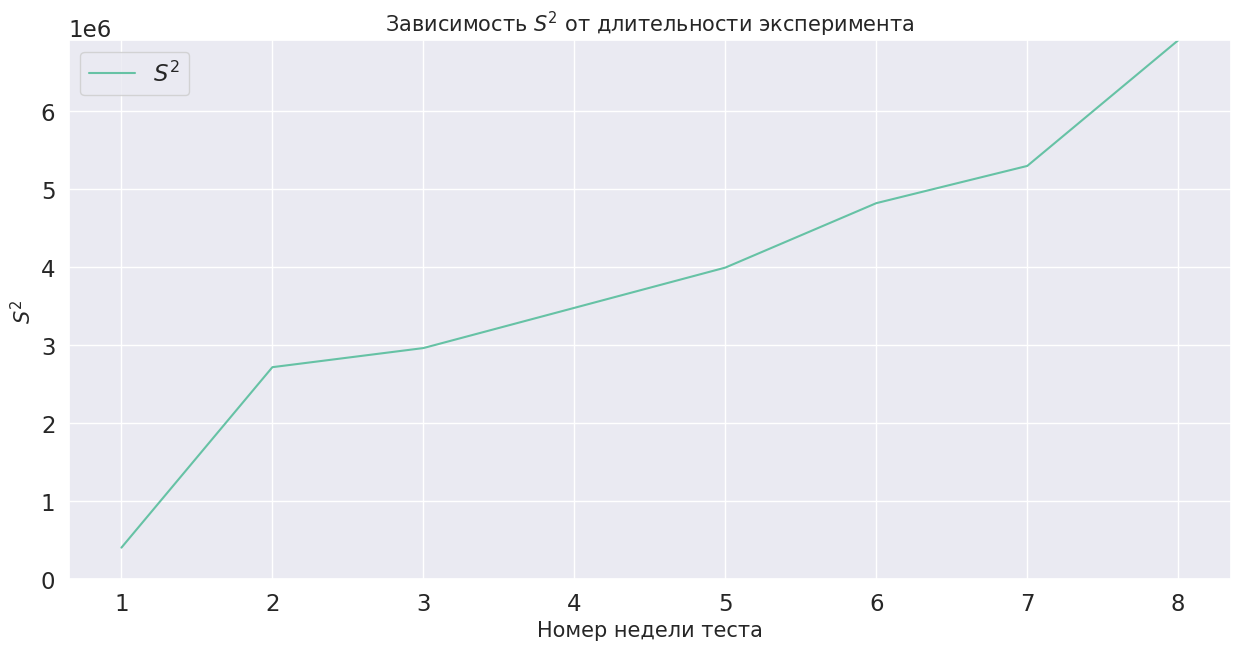

In [ ]:
weeks_length_array = np.arange(1, 9, 1)

metric = 'promotion_revenue'

S2_array = []
for weeks_length in weeks_length_array:
    curr_df = make_grouped_user_dataset(before_exp_dataset, weeks_length)
    S2 = np.var(curr_df[metric])
    S2_array.append(S2)

plt.figure(figsize=(15, 7))
plt.title('Зависимость $S^2$ от длительности эксперимента', fontsize=15)

plt.plot(weeks_length_array, S2_array, label='$S^2$')
plt.legend()
plt.ylabel('$S^2$ ', fontsize=15)
plt.xlabel('Номер недели теста', fontsize=15)
plt.ylim(0, max(S2_array) + 1)
plt.show()

График наглядно подтвержадет, что дисперсия не является константой с ростом длительности теста. Поэтому описанная ранее формула на практике не работает!

**Как правильно определять длительность теста?**

Предлагается не строить сложных моделей, а просто посчитать MDE на исторических данных с учетом разного числа недель в АА-тесте.

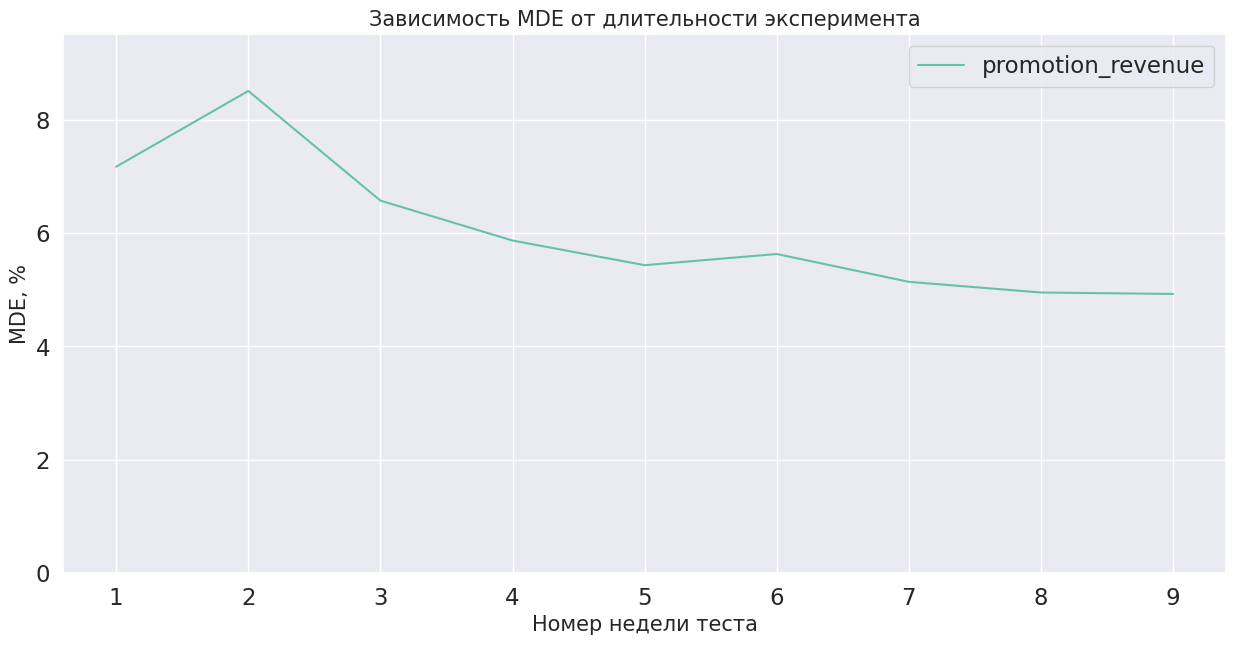

In [ ]:
MDE_week_array = []
metric = 'promotion_revenue'

weeks_length_array = np.arange(1, 10, 1)
for weeks_length in weeks_length_array:
    curr_df = make_grouped_user_dataset(before_exp_dataset, weeks_length)
    curr_df['group'] = np.random.choice(['test', 'control'], size=len(curr_df))

    test = np.array(curr_df[(curr_df['group'] == 'test')][metric])
    control = np.array(curr_df[(curr_df['group'] == 'control')][metric])
    MDE = get_relative_MDE(test, control, alpha=0.05, beta=0.2) * 100
    MDE_week_array.append(MDE)


plt.figure(figsize=(15, 7))
plt.title('Зависимость MDE от длительности эксперимента', fontsize=15)

plt.plot(weeks_length_array, MDE_week_array, label=metric)
plt.legend()
plt.ylabel('MDE, %', fontsize=15)
plt.xlabel('Номер недели теста', fontsize=15)
plt.ylim(0, max(MDE_week_array) + 1)
plt.show()

Мы видим, что зависимость нелинейная и не падает к нулую: она остановилась около 5% на 7 неделях. Этого достаточно, больше держать тест смысла нет.

In [ ]:
MDE_week_array[0] / MDE_week_array[6]

np.float64(1.395100886729453)

Из-за того, что мы будем держать тест не 1 неделю, а 7, то мы выиграем в 1.4 раза!

**Какие ещё факторы влияют на продолжительность теста?**

Помимо MDE, важно учитывать, что ваши бизнес-партнёры также стремятся получить результаты AB-теста в максимально сжатые сроки. Поэтому вам необходимо достичь разумного компромисса с ними. Ваша аргументация может звучать следующим образом: если мы проведем тест в течение X недель вместо предлагаемых Y недель, то сможем получить более точные результаты. Вместо того чтобы определять эффект в $\alpha\%$, мы сможем детектировать более мелкий эффект $\beta\%$, что может быть очень важно.

В идеале, было бы полезно продемонстрировать в деньгах, что $\beta\%$ также представляет значительный потенциал для бизнеса, и крайне важно иметь возможность выявлять такие эффекты.

Наш текущий MDE:

In [ ]:
print(f"Относительный MDE для метрики ARPU при правильном сетапе равен {round(MDE_week_array[6], 1)}%")

Относительный MDE для метрики ARPU при правильном сетапе равен 5.1%


Мы сократили наш MDE в 3 раза! Но 5% это все еще много.

#### 2.1.3 Метрики и прокси метрики

Еще один эффективный метод детектировать более мелкие эффекты – это работа с метрикой, а точнее работа с прокси-метриками.

Какая прокси-метрика хорошая? Она должна удовлетворять 2 правилам:
- Быть сонаправленной с вашей целевой метрикой. Это правило нужно для правильной бизнес-интерпретации: если мы вырастили эту метрику – значит, мы вырастили и нашу основную метрику.
- Иметь большую чувствительность, нежели ваша основная метрика. Это правило уже продиктовано статистикой.

**Внимание! Вы должны быть абсолютно уверены, что прокси метрика сонаправлена с вашей основной метрикой.** Если это будет не так, то смысла в прокси метрике нет. Так как гарантировать это в каждом отдельном случае очень сложно, то переход к прокси метрикам рекомендуется только в том случае, если все остальные методы грамотного сетапа теста с основной метрикой не помогли.

---

В нашем тесте прокрасить выручку – очень сложная задача. Как мы видим, у этой метрики MDE 5%. Поэтому надо придумать прокси метрику. Как стоит подходить к этой задаче?

**Основной метод нахождения прокси метрик – разложить вашу основную метрику на компоненты.** Или же, если использовать формальные термины, то это взять метрику выше по продуктовой воронке или по дереву метрик.

Если рассматривать наш пример, то
```
promotion_revenue =
    = promotion_listings * promotion_revenue_per_listing
    = promotion_listers * promotion_listings_per_promotion_lister * promotion_revenue_per_listing
```
Поэтому в нашем тесте предлагается использовать следующие "более чувствительные метрики".
- `promotion_listings` – число объявлений с покупкой продвижения.
- `promotion_listers` – число пользователей, купивших услугу продвижения.

Давайте посмотрим на истории, какая метрика более чувствительная и более скоррелирована с нашей финальной метрикой выручки.

Все остальные параметры возьмем максимально из нашего идеального сетапа для выручки: соберем данные за 7 недель и посмотрим на сетап 50% на 50%.

In [ ]:
current_dataset =  make_grouped_user_dataset(before_exp_dataset, 7)
current_dataset['group'] = np.random.choice(['test', 'control'], size=len(current_dataset))

for metric in ['promotion_revenue', 'promotion_listings', 'promotion_listers']:
    test = np.array(current_dataset[(current_dataset['group'] == 'test')][metric])
    control = np.array(current_dataset[(current_dataset['group'] == 'control')][metric])

    MDE = get_relative_MDE(test, control, alpha=0.05, beta=0.2)
    print(f'{metric} MDE: {round(MDE * 100, 1)}%')

promotion_revenue MDE: 5.2%
promotion_listings MDE: 4.1%
promotion_listers MDE: 1.7%


MDE для метрики `promotion_listers` является самым низким: он почти в три раза меньше, чем у `promotion_revenue`.

**Важно дополнение!** Нам нужно не только уменьшить MDE, но вы также должны иметь понимание, что на эту метрику вы будете сильно влиять! Например, если вы изменяете только метрику "средний чек на объявление" в вашем гипотетическом кейсе, и не меняете число юзеров, то нет  смысла брать метрику `promotion_listers`, даже если у нее малый MDE.


В нашем кейсе давайте смотреть `promotion_listers`: если нам удастся увеличить количество пользователей, которые воспользуются услугой продвижения, то мы будем считать тест успешным. Это вполне логично: если больше людей хотя бы раз воспользуются услугой, это принесёт больше денег сервису. Однако такой подход работает только при условии, что выручка у существующих пользователей услуги продвижения не уменьшится. В нашем случае это кажется правдоподобным, но мы можем дополнительно проверить это в AB-тесте. Достаточно оценить, не снизилась ли ratio-метрика `promotion_revenue / promotion_listers` и не уменьшилось ли количество `promotion_listings`. Однако стоит учесть, что эти метрики точно будут более шумными, поэтому их проверка в AB-тесте скорее носит характер дополнительной проверки.

Тогда наша финальная статистическая гипотеза:

$$
H_0: P_C = P_T\ vs. H_1:  P_C < P_T
$$

где $P$ &mdash; конверсия в покупку услуги продвижения за N недель.

Далее рассмотрим 3 важных замечания при использовании прокси метрик.

-----


##### 1. **Прокси-метрика – не универсальна! В каждом кейсе ее надо подбирать заново.**

Важно помнить, что прокси метрики не являются универсальными и могут различаться в зависимости от конкретного случая. Например, в ситуации, когда требуется изменить дизайн и описание услуги, `promotion_listers` будет подходящей прокси метрикой.

Но теперь посмотрим такой кейс:

> Вы хотите протестировать выдачу скидок на услугу продвижения новым пользователям. Увеличит ли это выручку?

В данном кейсе основная метрика &mdash; выручка, как и в нашем. Но! Если использовать метрику `promotion_listers` в качестве прокси метрики, по которой вы будете принимать решение, то вы точно раскатите это изменение, даже если оно ведет к падению выручки! Почему? Потому что в этом случае вы уменьшаете средний чек у всех пользователей, в том числе и у тех, кто воспользовался бы услугой и без скидки, что может привести к падению итоговой выручки (метрика `promotion_revenue / promotion_listers` упадет). **Поэтому в  кейсе со скидками `promotion_listers` &mdash; плохая прокси метрика!**


Как теперь понимать, в каком случае можно использовать ту или иную прокси метрику? Чаще всего это определяется логически, исходя из тестируемой механики. Надо понимать, можете ли вы уронить "соседствующую" метрику при разложении изначальной метрики, или нет? Но после "логики" обязательно должна следовать валидация: например, это можно подтвердить старыми АБ-тестами, если были похожие тесты.


##### **2. Какой эффект ожидать на основную метрику при переходе к прокси.**

Допустим, мы получим прирост `promotion_listers` на +X%. А в выручке это сколько?
- **1 вариант** `+X% proxy metric = +X% main metric`. Это предположение логично в случае, если вы не внесли изменения вашим экспериментом в конверсию второй составляющей при разбиении основной метрики на части. В нашем случае это означает, что соотношение `promotion_revenue / promotion_listers` осталось неизменным в нашем предположении.
- **2 вариант** Оценить падение воронки на верхних этапах, как эффект `promotion_listers` спадает при переходе к выручке? Чаще всего это делается на основании старых похожих AB-тестов, или на основании математических моделей, которые надо валидировать.

В нашем кейсе мы посчитаем, что у нас первый вариант.


##### **3. Интерпретация прокси-метрик: переход к сегментам пользователей.**

Иногда вместо замены основной метрики вы можете перейти к более узкому сегменту, где вы ожиадете основной эффект. Например, в данном случае вместо перехода к `promotion_listers` можно было бы смотерть эффект на выручку только среди пользователей, которые не пользовались услугой продвижения в течение нескольких последних месяцев. Если там есть положительный эффект &mdash; значит наш дизайн имеет смысл.

При переходе к новому, более узкому сегменту действуют все те же правила, что и переходе от метрики к прокси-метрике: вы должны быть уверены, что в нецелевом сегменте вы не ухудшили метрики.


#### 2.1.5 Когда стоит остановиться при подготовке сетапа теста?

Как понять, имеет ли смысл запускать с таким MDE (1.7%) или нет? Это все еще большой эффект или нет?

Ответ на этот вопрос зависит от вашего **ожидаемого эффекта в эксперименте**. Если он 0.5%, то такой сетап теста все еще плох. А если 2-3%, то вполне себе хорош.

**Как определить ожидаемый эффект в эксперименте до его начала?**

Есть 5 способов ответить на этот вопрос, перечислим их от лучшего к худшему.

1. Взять недавние похожие проведенные AB-тесты в компании и усреднить эффект у них.
    - Например, в нашем кейсе мы могли бы взять пример, когда тестировали новые услуги продвижения, какой там был эффект?
    - Или взять эффект в AB-тесте, где тестировали изменение дизайна в другом похожем продукте: например, изменение дизайна при размещении объявления.
2. Построить математическую модель, где часть коэффициентов взять из других тестов или экспертно.
3. Если первые 2 кейса не работают, то можно обратиться к бенчмаркам на рынке, или к внешним данным: вдруг кто-то опубликовал ресерч, как они сделали похожее изменение в своем продукте, и это привело к тем или иным результатам.
4. Далее, если и внешних данных нет, то оценить эффект экспертно: вероятно, ваш продукт-менеджер может прикинуть эффект исходя из своего опыта.
5. Если и это не работает, то ваш ожидаемый эффект = полученный MDE.

Ожидаемый эффект вы оцениваете на основании изменения прокси метрики.

#### 2.1.6 Итоги правильной подготовки сетапа теста

Теперь, вместо того, чтобы в AB-тесте:
- смотреть метрику `promotion_revenue`
- тестировать изменения на 10:10 процентах пользователей в каждой группе.
- держать тест 1 неделю

Мы поняли, что надо:
- смотреть метрику `promotion_listers` (сокращение MDE в 3 раза)
- тестировать изменения на 50:50 процентах пользователей (сокращение MDE в 2.2 раза)
- держать тест 7 недель (сокращение MDE в 1.4 раза)

Итоговое сокращение MDE будет в $3*2.2*1.4 = 9.2$ раза! Проверим это на наших предэкспериментальных данных:

In [ ]:
# Было
np.random.seed(42)
metric = 'promotion_revenue'
prepaired_for_aa_dataset = make_grouped_user_dataset(before_exp_dataset, weeks_in_test=1)
# Суммарно 20 процентов: 10 в тесте и 10 в контроле
prepaired_for_aa_dataset = prepaired_for_aa_dataset.sample(frac=0.2)
prepaired_for_aa_dataset['group'] = np.random.choice(['test', 'control'], size=len(prepaired_for_aa_dataset))

test = np.array(prepaired_for_aa_dataset[(prepaired_for_aa_dataset['group'] == 'test')][metric])
control = np.array(prepaired_for_aa_dataset[(prepaired_for_aa_dataset['group'] == 'control')][metric])

MDE_old = get_relative_MDE(test, control, alpha=0.05, beta=0.2) * 100

Тогда наш MDE при неправильном сетапе был:

In [ ]:
print(f"Изначальный MDE {round(MDE_old, 1)}%")

Изначальный MDE 18.7%


In [ ]:
# стало
np.random.seed(42)
metric = 'promotion_listers'
prepaired_for_aa_dataset = make_grouped_user_dataset(before_exp_dataset, weeks_in_test=7)
prepaired_for_aa_dataset['group'] = np.random.choice(['test', 'control'], size=len(prepaired_for_aa_dataset))

test = np.array(prepaired_for_aa_dataset[(prepaired_for_aa_dataset['group'] == 'test')][metric])
control = np.array(prepaired_for_aa_dataset[(prepaired_for_aa_dataset['group'] == 'control')][metric])

MDE_new = get_relative_MDE(test, control, alpha=0.05, beta=0.2) * 100

In [ ]:
print(f"Новый MDE {round(MDE_new, 1)}%")

Новый MDE 1.8%


In [ ]:
print(f"Сокращение MDE: {round(MDE_old/MDE_new, 1)}")

Сокращение MDE: 10.6


Да, все примерно совпало! Благодаря грамотному сетапу AB-теста мы сократили дов. интервал в 10 раз!

Сильнее всего на скоращение MDE повлиял переход на прокси-метрику в нашем кейсе.

### 2.2 Анализ результатов при хорошем сетапе. От серых результатов к прокрасам.

Посмотрим теперь, что у нас получилось на практике.

In [ ]:
exp_df = pd.read_csv('correct_exp_df_ab1.csv')

In [ ]:
exp_df.head()

,user_id,group,promotion_revenue,promotion_listings,promotion_listers,other_revenue
0,312000117,test,0.000000,0,0,0.000000
1,313250027,test,0.000000,0,0,0.000000
2,320501431,control,5218.765072,6,1,126.729412
3,320750021,control,0.000000,0,0,0.000000
4,321001342,test,0.000000,0,0,0.000000


In [ ]:
metric = 'promotion_listers'
test = np.array(exp_df[(exp_df['group'] == 'test')][metric])
control = np.array(exp_df[(exp_df['group'] == 'control')][metric])

MDE_new = get_relative_MDE(test, control, alpha=0.05, beta=0.2)

print(f"Относительный MDE равен {round(MDE_new * 100, 1)}%")

Относительный MDE равен 1.7%


Было 15.8%, стало 1.7% на более чувствительной метрике! Сокращение около 10 раз, как и на исскуственном примере. Кроме того, итоговый оцененный MDE на истории совпал с MDE на экспериментальном периоде.

А что теперь получилось с точки зрения стат значимости?

In [ ]:
results = absolute_ttest(control, test, two_sided_alpha=0.1)

print(f'Effect: {round(results.effect, 3)},({round(results.left_bound, 3)}, {round(results.right_bound, 3)})')
print(f'two-sided pvalue: {round(results.pvalue * 100, 1)}%, one-sided pvalue: {round(results.pvalue / 2 * 100, 1)}%')

Effect: 0.005,(0.002, 0.008)
two-sided pvalue: 1.2%, one-sided pvalue: 0.6%


pvalue < 0.05, а значит у нас с вами "зеленый" тест!


#### Виды результатов AB-тестов. Терминология.

Выделяют 3 результата AB-теста
- <span style="color:green">"зеленый прокрас"</span> &mdash; идеальное состояние. Ваша метрика стат. значимо улучшилась, как вы и хотели. Чаще всего это значит, что можно катить ваше изменение. Катить – значит запускать.
- <span style="color:lightgrey">"серый прокрас"</span> &mdash; грустный результат: вы не смогли получить стат. значимый эффект. Теперь вам надо разбираться, что с этим делать и почему так получилось.
- <span style="color:red">"красный прокрас"</span> &mdash; худшее состояние. Ваша метрика прокрасилась, но не в ту сторону: вы сделали хуже, чем было. И вам также надо разобраться в причинах таких результатов.


В нашем случае, в первой части лекции был серый результат, а стал зеленым!

### 2.3 Контр-метрики

Казалось бы, на этом можно было бы остановиться, но мы не учли, что наши изменения могут негативно сказаться на других метриках! Если текущая раскатка приведет к значительному негативному падению, который перевесит все положительные стороны от текущего изменения, то мы можем и отказаться от этой фичи.

Метрики, которые могут ухудшиться в ходе эксперимента, и они важны для компании и бизнеса, называются **контр-метриками**.

Ранее мы уже отмечали 2 метрики, которые не должны упасть, раз мы перешли к прокси метрике:
- ratio-метрика `promotion_revenue / promotion_listers`. как работать с такими метриками – прочитайте или посмотрите [лекцию 11 в курсе статистики](https://avito.tech/education/statistics).
- метрика `promotion_listings`

Кроме того, мы можем перейти к метрике `promotion_listers` только в случае, если будем уверены, что `promotion_revenue / promotion_listers` не упала, иначе результат по прокси метрике может быть не сонаправлен с `revenue`.

Но мы знаем, что:
1. По логике вещей, наши изменения не должны повлиять на эти показатели.
2. Эти метрики более "шумные", и мы вряд ли заметим в них какой-либо эффект.

Поэтому у нас не будет сильных ожиданий в прокрасах этих метрик, мы их смотрим больше информационно, дабы заметить, если что-то действительно пошло не так.

In [ ]:
# Создаем линеаризованную метрику promotion_revenue / promotion_listers

def linearisation(numerator, denominator):
    E_num = np.mean(numerator)
    E_den = np.mean(denominator)
    return E_num / E_den + 1 / E_den * (numerator - E_num / E_den * denominator)


def make_linearized_revenue_listers_metric(start_df):
    df = start_df.copy()

    df['lin_revenue_listers'] = 0

    for group in ['test', 'control']:
        revenue = np.array(df[(df['group'] == group)]['promotion_revenue'])
        listers = np.array(df[(df['group'] == group)]['promotion_listers'])

        df.loc[df['group'] == group, 'lin_revenue_listers'] = linearisation(revenue, listers)
    return df

In [ ]:
exp_df = make_linearized_revenue_listers_metric(exp_df)

for metric in ['lin_revenue_listers', 'promotion_listings']:
    test = np.array(exp_df[(exp_df['group'] == 'test')][metric])
    control = np.array(exp_df[(exp_df['group'] == 'control')][metric])

    results = absolute_ttest(control, test, two_sided_alpha=0.1)

    print(metric)
    print(f'Effect: {round(results.effect, 3)},({round(results.left_bound, 3)}, {round(results.right_bound, 3)})')
    print(f'two-sided pvalue: {round(results.pvalue * 100, 1)}%, one-sided pvalue: {round(results.pvalue / 2 * 100, 1)}%')
    print('----')

lin_revenue_listers
Effect: -56.987,(-181.318, 67.344)
two-sided pvalue: 45.1%, one-sided pvalue: 22.5%
----
promotion_listings
Effect: 0.035,(0.004, 0.066)
two-sided pvalue: 6.6%, one-sided pvalue: 3.3%
----


1. ratio-метрика `promotion_revenue / promotion_listers` стат значимо не изменилась, все отлично.
2. А `promotion_listings` прокрасилась в положительную сторону! А значит плюс еще одна прокси-метрика в подтвержедние раскатки теста.

Однако давайте обратим внимание на метрику `other_revenue`, которая показывает выручку от других продуктов продвижения, у которых мы не меняли дизайн. **Есть серьезные опасения, что мы могли ее каннибализировать**: пользователи стали покупать текущую услугу продвижения с новым дизайном и перестали покупать другие услуги из-за их ограниченности бюджета или менее привлекательного предложения по сравнению с текущей обновленной услугой. Мы не можем игнорировать эту метрику, даже если у неё широкий доверительный интервал.

In [ ]:
metric = 'other_revenue'
test = np.array(exp_df[(exp_df['group'] == 'test')][metric])
control = np.array(exp_df[(exp_df['group'] == 'control')][metric])

results = absolute_ttest(control, test, two_sided_alpha=0.1)

print(f'Effect: {round(results.effect, 1)} руб., ({round(results.left_bound, 1)}, {round(results.right_bound, 1)})')
print(f'two-sided pvalue: {round(results.pvalue * 100, 1)}%, one-sided pvalue: {round(results.pvalue / 2 * 100, 1)}%')

Effect: -6.5 руб., (-15.9, 3.0)
two-sided pvalue: 25.8%, one-sided pvalue: 12.9%


В данном случае нас не интересует просто прокрас/не прокрас, а нужно реальное понимание, насколько могло быть сильное падение? Она идеалогически могла полностью убрать эффект от теста.

Давайте посмотрим на относительный MDE.

In [ ]:
MDE = get_relative_MDE(test, control, alpha=0.05, beta=0.2)

print(f"Относительный MDE равен {round(MDE * 100, 1)}%")

Относительный MDE равен 5.4%


MDE большой, непонятно, что с этим делать. Для финального принятия решения нам не хватает лучшей визуализации и интерпретации результатов.

## Часть 3. Грамотная демонстрация результатов.

В этом разделе мы сосредоточимся на том, как грамотно представлять результаты, и продемонстрируем это на примере текущего кейса.

1. Смотреть и показывать p-value – непонятно ни вам, ни коллегам. Глядя на него, вы можете сказать, стало ли лучше или хуже, но не сможете определить насколько. Кроме того, вам будет сложно интерпретировать «серые» результаты: связана ли проблема с чувствительностью эксперимента или с небольшим эффектом?


Поэтому предлагается смотреть на доверительный интервал.

*Пример*: эффект на выручку +100 М, p-value 0.01 не так понятно как: эффект на выручку +100 М $\pm$ 50 M.

2. При этом, как мы уже убедились, абсолютные значения также могут быть трудно интерпретируемыми. Например, эффект 0.035 – `promotion_listings` это много или мало? Поэтому нам надо научиться строить все метрики относительно, в том числе и доверительные интервалы. Так результаты сильно более интерпретируемы. Но, как мы увидим далее, это не так просто.

*Пример*: эффект +20000 покупок в месяц не так понятно, как +5% покупок в месяц.

### 3.1 Доверительный интервал для относительного эффекта

Первое, что **вам не надо делать** – это посчитать дов. интервал для абсолютного эффекта и потелить его на среднее в контроле.

![](https://habrastorage.org/r/w1560/getpro/habr/upload_files/9d3/af0/9e7/9d3af09e7fa3c6fc108096f7c4ab9f61.png)

Почему? Читай [тут](https://habr.com/ru/companies/avito/articles/571094/),  секция "Относительный T-test критерий".

Правильный интервал для отношения мат. ожиданий можно вывести 2 способами: через линеаризацию или через дельта-метод. Оба этих метода мы уже [разбирали на курсе статистики](https://avito.tech/education/statistics#:~:text=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D0%B8%D1%87%D0%BA%D0%B0%20%D0%BA%20%D1%83%D1%80%D0%BE%D0%BA%D1%83-,11.%20%D0%9B%D0%B8%D0%BD%D0%B5%D0%B0%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F,-11.4.%20Ratio%2D%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%BA%D0%B8), поэтому сейчас предлагаю воспользоваться дельта-методом и решить эту задачу.

- Статистика $\dfrac{\overline{T} - \overline{C}}{\overline{C}}$ будет из нормального распределения $ \mathrm{N}\left(\dfrac{\mathbb{E}  T - \mathbb{E} C}{\mathbb{E}  C} ,\mathbf{D}\right)$, где дисперсия расписывается ниже:
![](https://habrastorage.org/getpro/habr/upload_files/d22/ed6/2a7/d22ed62a7b2338f9dcaccac7a088891c.png)

    - Свойство следует напрямую из теоремы [дельта-метода](https://ru.wikipedia.org/wiki/Дельта-метод_(статистика)).
- Подставляя вместо ковариации, дисперсии и мат. ожидания оценочные функции (`np.cov`, `np.var`, `np.mean`) можно получить итоговый критерий. Доказательство полностью аналогично тому, как мы доказывали нормальную аппроксимацию для t-test критерия ([ищите в методичке t-test](https://github.com/avito-tech/applied_statistics/blob/main/T-test.ipynb) раздел `t'-test`).

In [ ]:
def relative_ttest(control, test, two_sided_alpha):

    mean_control = np.mean(control)
    var_mean_control  = np.var(control) / len(control)

    difference_mean = np.mean(test) - mean_control
    difference_mean_var  = np.var(test) / len(test) + var_mean_control

    # Это следует из того, что тест и контроль независимы между собой.
    covariance = -var_mean_control

    # наша оценка эффекта
    relative_effect = difference_mean / mean_control

    # Реализовали страшную формулу выше
    relative_var = difference_mean_var / (mean_control ** 2) \
                    + var_mean_control * ((difference_mean ** 2) / (mean_control ** 4))\
                    - 2 * (difference_mean / (mean_control ** 3)) * covariance
    relative_distribution = sps.norm(loc=relative_effect, scale=np.sqrt(relative_var))

    # Доверительный интервал – это просто квантили нашего распределения.
    left_bound, right_bound = relative_distribution.ppf([two_sided_alpha / 2, 1 - two_sided_alpha / 2])
    ci_length = (right_bound - left_bound)
    pvalue = 2 * min(relative_distribution.cdf(0), relative_distribution.sf(0))
    return ExperimentComparisonResults(pvalue, relative_effect, ci_length, left_bound, right_bound)


Давайте проверим на искусственном Монте-Карло, что критерий верен:

In [ ]:
bad_cnt = 0

N = 1000
for i in tqdm_notebook(range(N)):
    control = sps.expon(scale=1000).rvs(1000)
    # Мат. ож в 1.1 раза больше
    test = sps.expon(scale=1100).rvs(1000)

    _, _, _, left_bound, right_bound = relative_ttest(control, test, two_sided_alpha=0.1)
    if left_bound > 0.1 or right_bound < 0.1:
        bad_cnt += 1

left_real_level, right_real_level = proportion_confint(count = bad_cnt, nobs = N, alpha=0.05, method='wilson')
# Результат.
print(f"Реальный уровень значимости: {round(bad_cnt / N, 4)};"
      f" доверительный интервал: [{round(left_real_level, 4)}, {round(right_real_level, 4)}]")

  0%|          | 0/1000 [00:00<?, ?it/s]

Реальный уровень значимости: 0.096; доверительный интервал: [0.0793, 0.1158]


Да, всё верно!

----

Давайте теперь посмотрим на результаты теста в таком случае случае для всех метрик:

In [ ]:
results_dict = {}
for metric in ['lin_revenue_listers', 'promotion_listings', 'other_revenue', 'promotion_listers']:
    test = np.array(exp_df[(exp_df['group'] == 'test')][metric])
    control = np.array(exp_df[(exp_df['group'] == 'control')][metric])
    results = relative_ttest(control, test, two_sided_alpha=0.1)
    delta = results.ci_length / 2
    results_dict[metric] = results
    print(f'{metric}: {round(results.effect * 100, 1)}% ± {round(delta * 100, 1)}%')

lin_revenue_listers: -1.9% ± 4.1%
promotion_listings: 3.5% ± 3.2%
other_revenue: -2.5% ± 3.5%
promotion_listers: 1.8% ± 1.2%


В таком представлении результаты кажутся сильно более наглядными **по отдельности**.

Но мы все еще не можем понять: `other_revenue: -2.5% ± 3.5%` перекрывает ли эффект `promotion_listers: 1.8% ± 1.2%` или нет?

Для этого давайте посмотрим соотношение `other_revenue` и `promotion_revenue` между собой.

In [ ]:
other_sum = np.sum(np.array(exp_df[(exp_df['group'] == 'control')]['other_revenue']))
promotion_sum = np.sum(np.array(exp_df[(exp_df['group'] == 'control')]['promotion_revenue']))
full_revenue = other_sum + promotion_sum

other_pct = np.sum(other_sum) / np.sum(full_revenue) * 100
print(f"other_revenue / full revenue = {round(other_pct, 0)}%")

other_revenue / full revenue = 25.0%


`other_revenue` составляет 25% от всей выручки, а `promotion_revenue` составляет 75%.

Как мы говорили ранее, мы логично предполагаем, что рост `promotion_listers` ведет к такому же росту `promotion_revenue`. У нас нет опасений, что `promotion_revenue / promotion_listers` упал.

Тогда наши результаты по метрике и контр-метрике можно сравнивать:

In [ ]:
pct_dict = {
    'other_revenue': 0.25,
    'promotion_listers': 0.75
}
for metric in pct_dict:
    curr_results = results_dict[metric]
    delta = curr_results.ci_length / 2
    coeff = pct_dict[metric]
    print(f'{metric} revenue influence: {round(curr_results.effect * 100 * coeff, 1)}% ± {round(delta * 100 * coeff, 1)}%')

other_revenue revenue influence: -0.6% ± 0.9%
promotion_listers revenue influence: 1.3% ± 0.9%


То есть оценочно выручка выросла на 0,7% (= 1,3 - 0,6). А какой доверительный интервал? Так как средние по ЦПТ из нормального распределения, то это можно просто вывести математически, но легче насемплировать:

In [ ]:
std = 0.9 / sps.norm().ppf(1 - alpha)
other_revenue_effect_gen_sample = sps.norm(loc=-0.6, scale=std).rvs(1000)
promo_revenue_effect_gen_sample = sps.norm(loc=1.3, scale=std).rvs(1000)

left, right = np.quantile(other_revenue_effect_gen_sample + promo_revenue_effect_gen_sample, [0.05, 0.95])

print(f"full revenue effect CI: ({round(left, 1)}%, {round(right, 1)}%)")

full revenue effect CI: (-0.4%, 2.0%)


У нас нет точных доказательств того, что выручка не могла снизиться, но мы знаем, что её падение не превысило 0,4%.

Обладая этими данными, вы и ваш бизнес-партнёр сможете более обоснованно принять решение о внедрении нового дизайна. В этом случае, скорее всего, будет решено катить изменение. Мы улучшили и сделали текущую услугу более понятной для пользователей, что, как минимум, привело к увеличению числа покупок и покупателей. При этом не было замечено снижения выручки в других источниках продвижения. А суммарное, максимально возможное, падение выручки оказалось не таким значительным.

*На будущее: важно при сетапе теста также не забывать и про рассчет MDE для контр-метрик.*


## Часть 4. Пайплайн AB-тестов, начальная версия.

Методология AB-теста делится на 3 этапа:
1. Сетап теста.
    1. Определите основную метрику теста исходя из бизнес логики. Сформулируйте статистическую гипотезу, зафиксируйте критерий, определите уровень значимости, или False Positive Rate.
    2. Определите контр-метрики вашего теста.
    3. Оцените ожидаемый эффект на основную метрику.
    4. Определите оптимальный сетап теста по MDE.
        1. Определите размер групп в тесте и в контроле.
        2. Определите длительность теста.
        3. MDE получился меньше ожидаемого эффекта? Тогда переходите к запуску теста.
        4. Если нет, то определите прокси-метрики: пробило ли MDE какой-то из метрик ожидаемый результат? Добавьте остальные метрики при разбиении нашей начальной метрики на части, как контр-метрики для health чека вашего AB-теста.
        5. Проверьте, что у основной контр-метрики не очень широкий доверительный интервал. На практике не столь обязательный шаг, но очень желательный. Идеально – провернуть с ним всё то же самое, что и с основной метрикой.
2. Проведение теста. Подождите заранее зафиксированного срока на этапе сетапа теста.
3. Анализ результатов.
    - Оцените результаты выбранным ранее критерием.
    - Не забывайте правильно визуализировать и интерпретировать результаты. Здесь вам на помощь может прийти относительный T-test.

## Часть 5. Итоги

В этой статье мы с вами рассмотрели несколько важных аспектов AB-тестирования:

- Поняли, что такое AB-тестирование на практике.
- Ознакомились с основами грамотного сетапа AB-тестов.
- Научились правильно анализировать и представлять результаты AB-тестов, включая относительный T-test.

На этом всё! Если вы внимательно изучите весь материал, то сможете успешно пройти собеседование по AB-тестам на должность аналитика.